In [19]:
%run '../lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [20]:
dfRaw = load_df('dfRaw')

##### Investigate 3298 null values in response_correctness

- Check correlations
- Missing at random?

###### Select the  3298 null values in response_correctness

In [21]:
rcNullDf = dfRaw.filter(F.col('response_correctness').isNull() )

In [22]:
cols = single_val(rcNullDf.toPandas())
display_sv_cols(rcNullDf, cols)


,0
assignment_max_attempts,1
assignment_late_submission,False
assignment_attempt_number,1
is_manual_scoring_required,False
item_is_offline_scored,False
learner_attempt_status,fully scored
scoring_type_code,[unassigned]
response_correctness,None
is_deleted,False


- New Single values
  - Values
    - item_is_offline_scored = False (scored automatically)
    - scoring_type_code = "[unassigned]" (scored manually by human)
    - response_correctness = "None" (actually null)
  - "[unassigned]" is an unexpected value possibly indicating a automated scoring anomaly

###### Are these scores similar to population scores?

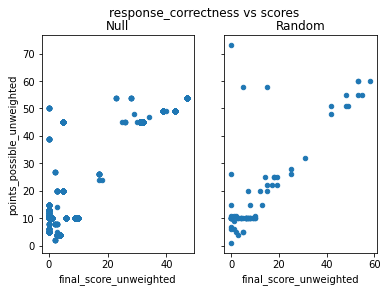

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

rcNullDf.toPandas().plot.scatter('final_score_unweighted', 'points_possible_unweighted', title='Null', ax=ax1)
dfRaw.sample(False, .001, 8764664).toPandas().plot.scatter('final_score_unweighted', 'points_possible_unweighted', title='Random', ax=ax2)
plt.suptitle('response_correctness vs scores')

plt.show()

- Score distribution similar to random sample of full dataset

###### Display Interval Statistics for null and all


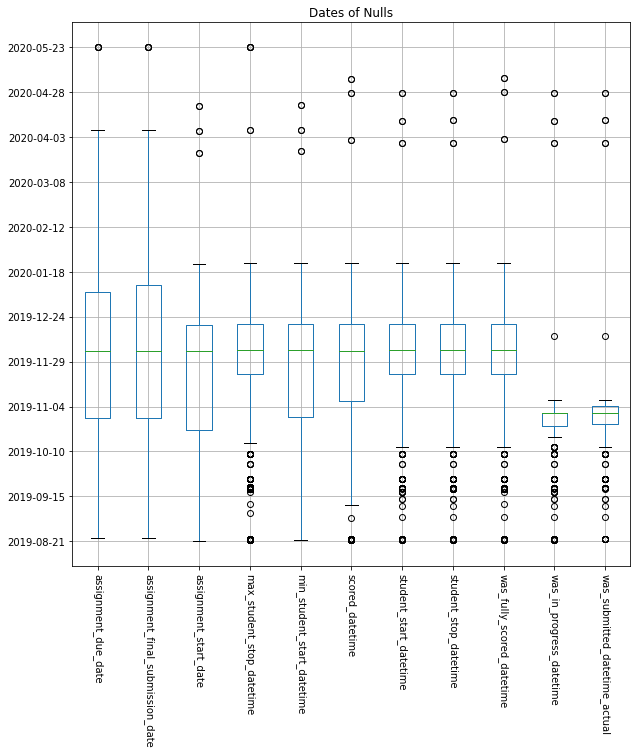

In [24]:
pdDf = rcNullDf.select(* (F.unix_timestamp(c).alias(c) for c in shared3['intervalVars']) ).toPandas()
date_boxplot(pdDf, "Dates of Nulls")

- Population dates
  - Equal distribution between 8/2019 and 5/2020
- Sample dates
    - Majority of nulls between 10/2019 and 1/2020
      - max_student_stop_datetime
      - student_start_datetime
      - student_stop_datetime
      - was_fully_scored_datetime
    - was_in_progress_datetime and was_submitted_datetime_actual
      - between 10/2019 and 11/2019

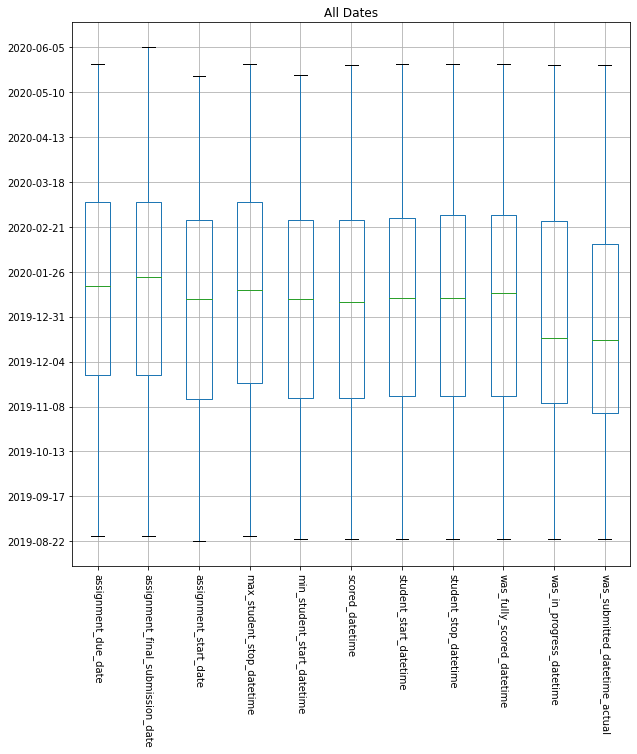

In [25]:
pdDf = dfRaw.sample(False, .01, 8764664).select(* (F.unix_timestamp(c).alias(c) for c in shared3['intervalVars']) ).toPandas()
date_boxplot(pdDf, "All Dates")

###### Population response_correctness values

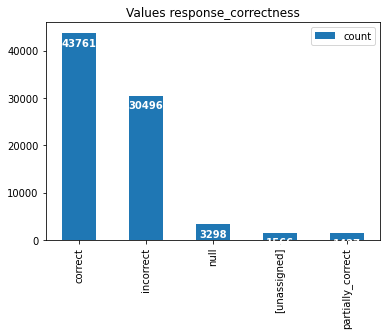

In [26]:
pdDf = dfFlt.groupBy('response_correctness').count().orderBy('count', ascending=False).toPandas()
ax = pdDf.plot.bar()
labels = pdDf['response_correctness'].fillna('null').tolist()
ax.set_xticklabels(labels=labels)
ax.set_title('Values response_correctness')
annotate_plot(ax)

- By definition response_correctness should be correlated to the final score
- Score possible and final points scale vary by question
- Need to convert to categorical to measure correlation

###### Cross tabulation of response_correctness to score converted to letter grade

In [28]:
score_bins   = [0,   59,  69,  79,  89, 100]
letter_grade = ['F', 'D', 'C', 'B', 'A']

pdDf =  dfRaw.withColumn(
    'percent_score',
    F.col('final_score_unweighted') / F.col('points_possible_unweighted') * 100
).select(
    'points_possible_unweighted',
    'final_score_unweighted',
    'response_correctness',
    'percent_score').toPandas()
pdDf['letter_grade'] = pd.cut(pdDf.percent_score, score_bins, labels=letter_grade)

pd.crosstab(pdDf.letter_grade, pdDf.response_correctness)

response_correctness,[unassigned],correct,incorrect,partially_correct
letter_grade,,,,
F,684,5908,11103,450
D,70,3171,1825,176
C,242,5074,1878,165
B,160,8118,1740,326
A,400,20525,888,269


- Uncorrelated scores and response_correctness values
  - 5908 correct when score says it's an failure (F)
  - 888 incorrect when scores says it's excellent (A)
  - Reviewed results with McGraw Hill and they recomend not using response_correctness
  - Will remove as suggested

In [29]:
finish_todo('Investigate 3298 null values in response_correctness')

add_todo('Remove 3298 null values in response_correctness')